In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [2]:
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts, v=v,dt=dt):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    # At present v is a dummy parameter
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts, v=v,dt=dt):
    # adjust scaling constant for desired turn radius
    x0, y0, t0 = curr_pose
    theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
    x= x0 + np.cumsum(v*np.cos(theta)*dt)
    y= y0 + np.cumsum(v*np.sin(theta)*dt)
    return x, y, theta

def inplace(change, curr_pose, n=num_pts, v=v, dt=dt):
    # v is a dummy variable
    return turn(change, curr_pose,n,0,dt)

def reverse(dist, curr_pose, n=num_st_pts, v=v,dt=dt):
    return straight(-dist, curr_pose, n=num_st_pts, v=v,dt=dt)
    
def change_lane(side,curr_pose,n=10,v=v,dt=dt):
    if side > 0: # new lane is in 
        theta = cubic_spiral(curr_pose[2],curr_pose[2]-np.pi/2,n=n).tolist()
        theta.extend( cubic_spiral(curr_pose[2]-np.pi/2,curr_pose[2],n=n).tolist() )
        x = curr_pose[0] + np.cumsum(v*np.cos(theta)*dt)
        y = curr_pose[1] + np.cumsum(v*np.sin(theta)*dt)
        
    else:
        theta = cubic_spiral(curr_pose[2],curr_pose[2]+np.pi/2,n=n).tolist()
        theta.extend( cubic_spiral(curr_pose[2]+np.pi/2,curr_pose[2],n=n).tolist() )
        x = curr_pose[0] + np.cumsum(v*np.cos(theta)*dt)
        y = curr_pose[1] + np.cumsum(v*np.sin(theta)*dt)
    return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2),v_straight=v,v_turn=v,dt=dt):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn, 'inplace': inplace, "reverse":reverse, "change-lane": change_lane}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose,v=v_straight if manoeuvre == "straight" or manoeuvre == "reverse" else v_turn,dt=dt)
        curr_pose = px[-1],py[-1],pt[-1]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return x, y, t

<IPython.core.display.Javascript object>


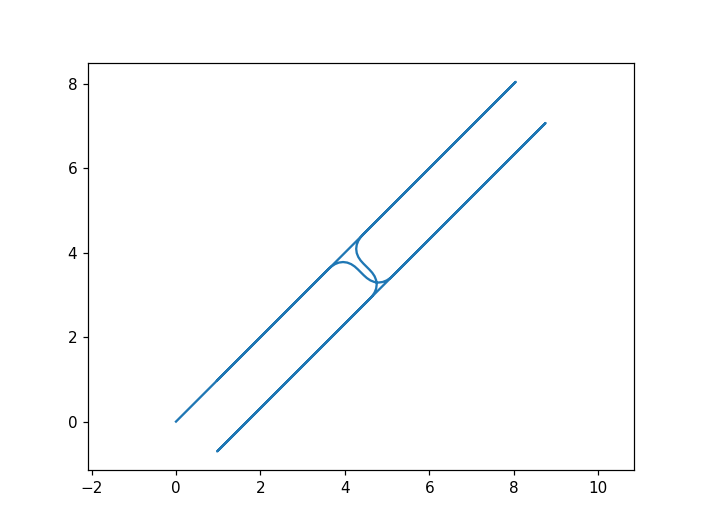

In [3]:
# Testing change-lane, reverse and inplace
route=[("straight",5),("change-lane",1),("straight",5),("reverse",11),("straight",5),("change-lane",-1),("straight",5),("inplace",180),("straight",10)]
x,y,_ = generate_trajectory(route,(0,0,np.pi/4))
plt.figure()
plt.axis("equal")
plt.plot(x,y)
plt.show()

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

<IPython.core.display.Javascript object>


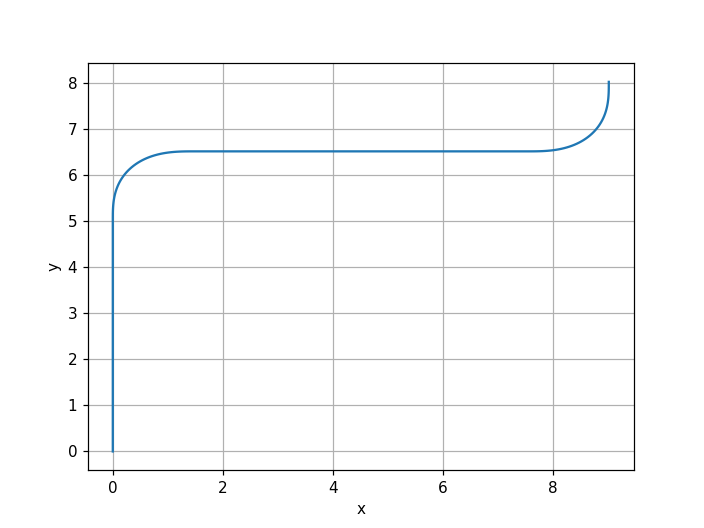

<IPython.core.display.Javascript object>


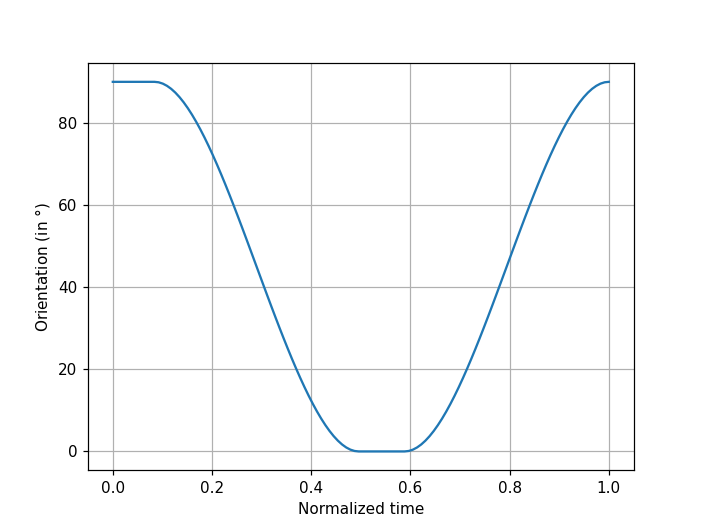

In [4]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x, y, theta = generate_trajectory(route,v_straight=1,v_turn=0.5)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,1,theta.shape[0]),np.rad2deg(theta))
plt.xlabel("Normalized time")
plt.ylabel("Orientation (in $\\degree$)")
plt.grid()
plt.show()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

<IPython.core.display.Javascript object>


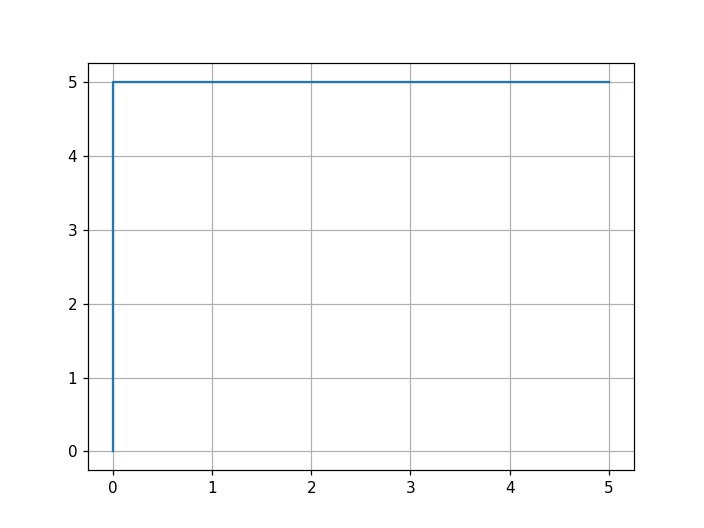

[('straight', 4.99), ('turn', -90), ('straight', 4.99)]


<IPython.core.display.Javascript object>


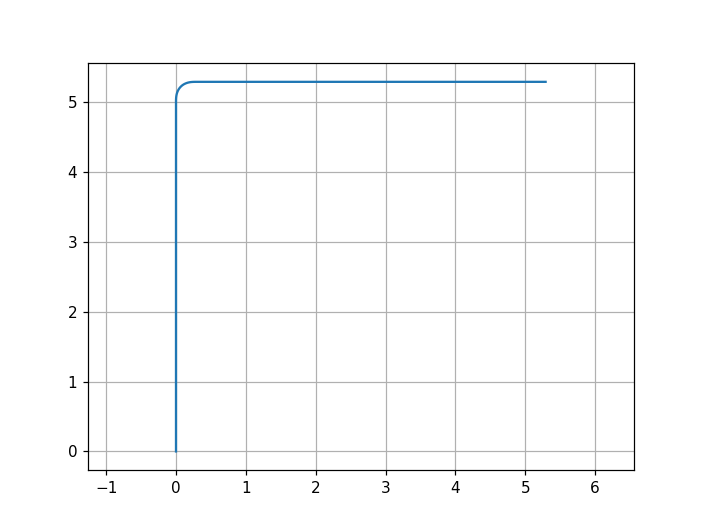

In [5]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
corners = [(0,0)]
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
    slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
    if np.abs(slope) > 0.0:
        corners.append([x2, y2])

# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}

route = []
pre_x, pre_y, theta = 0, 0, 90
corners.append([5,5])

epsilon = 1e-9

def corners_to_route(corners,r=0.1):
    # This will malfunction if corners are placed such a way that 
    pre_x, pre_y = corners[0]
    route = []
    x,y = corners[1]
    init_pose = (pre_x,pre_y,np.pi/2)
    
    if x > pre_x + epsilon:
        init_pose = (pre_x, pre_y,0)
    elif x < pre_x - epsilon:
        init_pose = (pre_x, pre_y,np.pi)
    elif y > pre_y + epsilon:
        init_pose = (pre_x, pre_y,np.pi/2)
    elif y < pre_y - epsilon:
        init_pose = (pre_x, pre_y,-np.pi/2)

    for i in range(1,len(corners)):
        R = r if i==1 or i == len(corners)-1 else 2*r
        x, y = corners[i]
        if abs(pre_x -x) < epsilon:
            route.append(("straight",abs(y-pre_y)-R))
        else:
            route.append(("straight",abs(x-pre_x)-R))
        if i < len(corners)-1:
            next_x = corners[i+1][0]
            next_y = corners[i+1][1]
            slope = (x-pre_x)*(next_y-y) - (next_x-x)*(next_y-pre_y)
            if slope > 0:
                route.append(("turn",90))
            elif slope < 0:
                route.append(("turn",-90))

        pre_y = y
        pre_x = x
    return route, init_pose
            
route,init_pose = corners_to_route(corners,r=0.01)
    

# use generate_trajectory() and plot the smooth path
print(route)
x, y, _ = generate_trajectory(route,init_pose,v_turn=0.1)
plt.figure()
plt.plot(x, y)
plt.axis("equal")
plt.grid()

## Testing corners_to_route

[('straight', 0.98), ('turn', 90), ('straight', 0.96), ('turn', -90), ('straight', 0.98)]


<IPython.core.display.Javascript object>


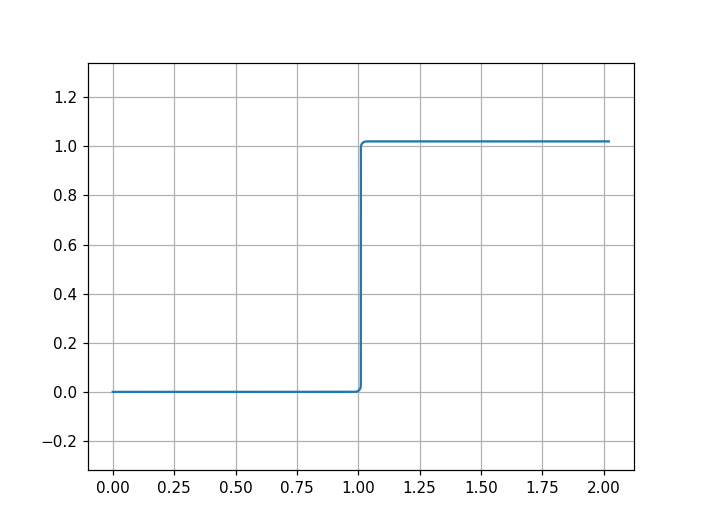

In [6]:
corners = [(0,0),(1,0),(1,1),(2,1)]
route, init_pose = corners_to_route(corners,r=0.02)
print(route)
x, y, _ = generate_trajectory(route,init_pose, v_turn=0.01)
plt.figure()
plt.plot(x, y)
plt.axis("equal")
plt.grid()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

In [7]:
grid = np.load("data/astar_grid.npy")

In [8]:
astar_path = [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]
astar_y, astar_x = zip(*astar_path)
astar_y, astar_x = list(astar_y), list(astar_x)

In [9]:
start = (0, 0)
goal = (0, 19)

# Populate corners
corners = []
corners.append([start[1],start[0]])
for x1,x2,x3, y1,y2,y3 in zip(astar_x[:-2],astar_x[1:-1],astar_x[2:],astar_y[:-2],astar_y[1:-1],astar_y[2:]):
    slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
    if np.abs(slope) > 0.0:
        corners.append([x2, y2])
corners.append([goal[1],goal[0]])

route,init_pose = corners_to_route(corners, r=0.02)

# use generate_trajectory() and plot the smooth path
x, y, _ = generate_trajectory(route,init_pose,v_straight=0.1,v_turn=0.001)

<IPython.core.display.Javascript object>


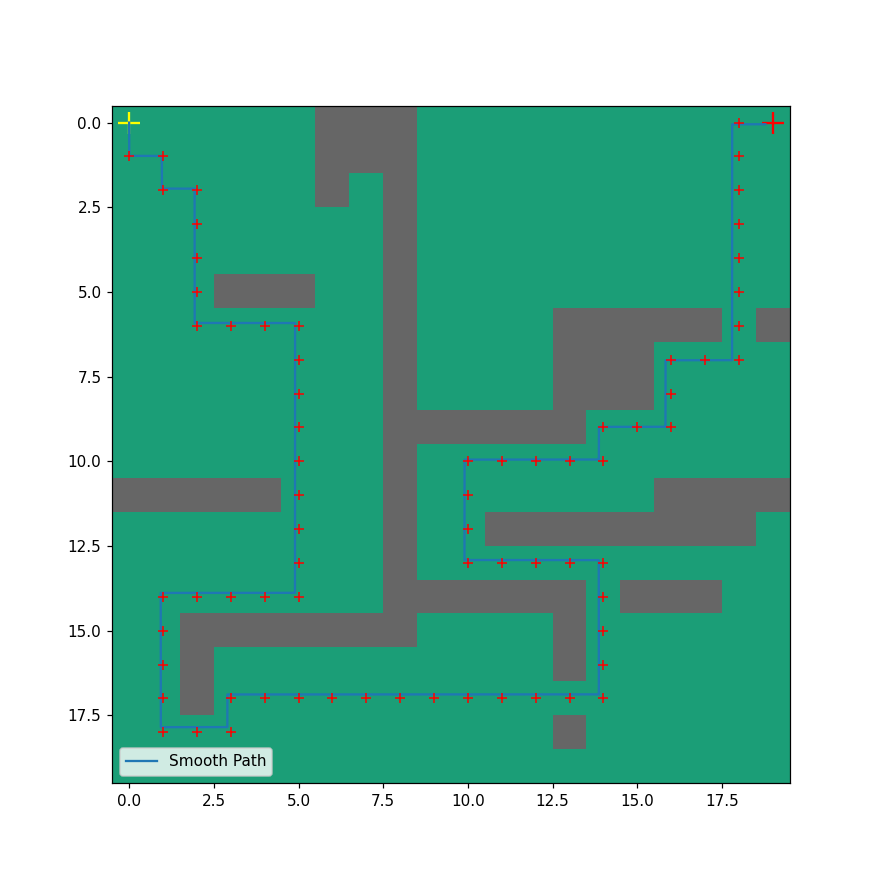

In [10]:

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
ax.plot(x,y, label="Smooth Path")
for s in astar_path[1:]:
    ax.plot(s[1], s[0],'r+')
plt.legend()
plt.show()

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs

In [11]:
# Implemented in cell 2